<a href="https://colab.research.google.com/github/amrios80/MINE_4210_ADL_202520/blob/main/labs/Laboratorio_5/MINE__4210_ADL_202520_L5_Entregable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo ADL](https://github.com/nicolastibata/MINE_4210_ADL_202520/blob/main/docs/images/logo.png?raw=true)


# **Laboratorio 5: Redes CNN para detección de objetos**
**Tutor: Nicolás Tibatá**

## **Tabla de Contenido**

[Contexto y objetivos](#scrollTo=5KnQpgpopi8a)<br>
[1. Introducción de los datos](#scrollTo=VjA8zwzJvmeO)<br>
[2. Preparación y Modelamiento](#scrollTo=kG8XHROzvuEH)<br>
[3. Taller 2](#scrollTo=JTKc52_Wvs_N)<br>

### **Contexto y Objetivos**

En este taller trabajaremos con el tema de la **detección de objetos**, que consiste en localizar y clasificar múltiples objetos dentro de una imagen. Esta técnica tiene aplicaciones en diversos campos, como:

- **Seguridad**: detección de personas, rostros o vehículos en sistemas de videovigilancia.  
- **Automoción**: identificación de peatones y señales de tránsito en vehículos autónomos.  
- **Agricultura**: conteo de plantas o frutos en imágenes aéreas.  
- **Medicina**: localización de anomalías en imágenes médicas como radiografías o resonancias magnéticas.  

El algoritmo **YOLO** (*You Only Look Once*) es conocido por realizar detecciones en tiempo real mediante una sola pasada de la imagen. Desde su primera versión en 2016, ha evolucionado hasta **YOLOv11**, que introduce mejoras en la arquitectura y en la velocidad de entrenamiento.

## Objetivos

1. **Entender la arquitectura de YOLO** y sus componentes principales (*Backbone*, *Neck* y *Head*).  
2. **Preparar un conjunto de datos** en formato YOLO para entrenamiento.  
3. **Entrenar un modelo YOLOv11** utilizando un dataset de detección de animales.  
4. **Evaluar el rendimiento del modelo** mediante métricas como mAP50 y mAP50–95.  
5. **Explorar configuraciones avanzadas** como variantes del modelo (*nano*, *small*, *medium*) y ajustes de hiperparámetros.  


**Datos:** [traffic-sign-detection](https://www.kaggle.com/datasets/pkdarabi/cardetection)

### **1. Introducción a los datos**

In [17]:
# Instalación e Importación de librerías
!pip install ultralytics -q

import os
import glob
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image as PImage
from PIL import ImageDraw
from IPython.display import display

from google.colab import files
from google.colab import userdata

In [22]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adrianamariarios","key":"636170a31f11fe8cb07f3204ae8200b7"}'}

In [23]:
import os
import shutil

os.makedirs('/root/.kaggle', exist_ok=True)

# Mover kaggle.json al directorio .kaggle
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

# Dar permisos correctos
os.chmod('/root/.kaggle/kaggle.json', 600)

In [24]:
#os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
#os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

from google.colab import userdata
userdata.get('adrianamariarios')

!kaggle datasets download -d pkdarabi/cardetection
!unzip "cardetection.zip"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: car/train/labels/00000_00003_00024_png.rf.08957035e670072dbb22d8f9905e9b84.txt  
  inflating: car/train/labels/00000_00003_00025_png.rf.11e558fae394d310693ee9223b8962ca.txt  
  inflating: car/train/labels/00000_00003_00026_png.rf.1f6b33373353f896f2c2025ffd264e51.txt  
  inflating: car/train/labels/00000_00003_00026_png.rf.a3b6c2dcd4ee9a8064667b7bb266590b.txt  
  inflating: car/train/labels/00000_00003_00027_png.rf.c1381ed46ee0d7e21877ea3d7ef86127.txt  
  inflating: car/train/labels/00000_00003_00029_png.rf.8e24d2606537779612888c6a06c7043d.txt  
  inflating: car/train/labels/00000_00004_00000_png.rf.45dccdbf08ed12f25d7742d8bf88c102.txt  
  inflating: car/train/labels/00000_00004_00001_png.rf.557d3494b3e633e29069a6f42918334e.txt  
  inflating: car/train/labels/00000_00004_00002_png.rf.3e3e95e1ba16cac885d3de7864a40fb4.txt  
  inflating: car/train/labels/00000_00004_00003_png.rf.9c6ba4d0186eec82a26bddc9a1204efb.txt  

El conjunto de datos está organizado en tres particiones principales: `train`, `valid` y `test`. Cada partición contiene dos subcarpetas:

- `images/`: Contiene las imágenes en formato `.jpg` o `.png`.  
- `labels/`: Contiene las etiquetas en formato `.txt`, donde cada archivo describe las clases y las coordenadas de las cajas delimitadoras (*bounding boxes*).  

       count
train   3530
valid    801
test     638


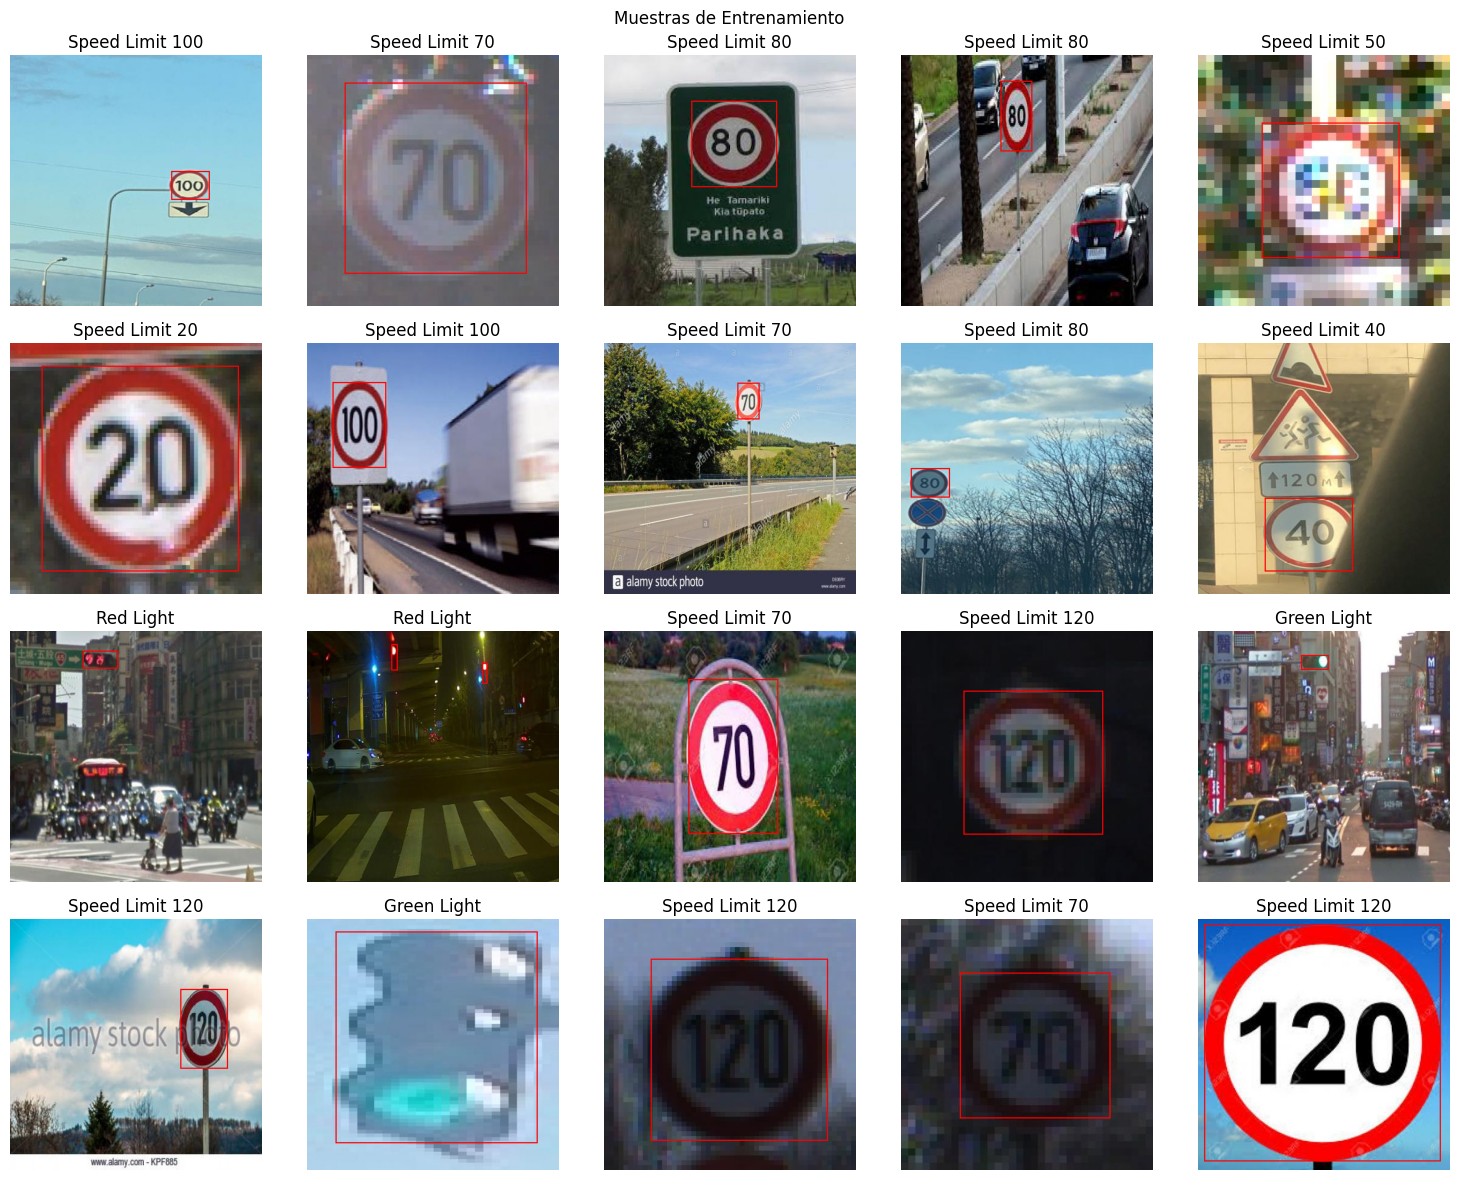

In [25]:
DATA_ROOT = Path('car')
if not DATA_ROOT.exists():
    raise FileNotFoundError(f"Ruta de datos no encontrada: {DATA_ROOT}")

root = DATA_ROOT
train_img = root / 'train' / 'images'
train_lbl = root / 'train' / 'labels'

# Definir clases
class_names = [
'Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', 'Speed Limit 110', 'Speed Limit 120',
'Speed Limit 20', 'Speed Limit 30', 'Speed Limit 40', 'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70',
'Speed Limit 80', 'Speed Limit 90', 'Stop'
]

# 1. Conteo de imágenes y distribución numérica
counts = {}
for split in ['train', 'valid', 'test']:
    path = root / split / 'images'
    counts[split] = len(list(path.glob('*.*'))) if path.exists() else 0

# Mostrar tabla de distribución
dist = pd.Series(counts, name='count')
print(dist.to_frame())

# 2. Visualizar muestras con bounding boxes y título de clase
population = list(train_img.glob('*.*'))
if not population:
    raise FileNotFoundError(f"No se encontraron imágenes en {train_img}")

# Tomar hasta 20 muestras
k = min(20, len(population))
sample_images = random.sample(population, k)

n_cols = 5
n_rows = (k + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))

for ax, img_path in zip(axes.flatten(), sample_images):
    img = PImage.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    w, h = img.size

    lbl_path = train_lbl / f"{img_path.stem}.txt"
    title_labels = set()
    if lbl_path.exists():
        for line in lbl_path.read_text().splitlines():
            cls, x_c, y_c, bw, bh = map(float, line.split())
            # Convertir a coordenadas de pixeles
            cx, cy = x_c * w, y_c * h
            bw_pix, bh_pix = bw * w, bh * h
            x1, y1 = cx - bw_pix/2, cy - bh_pix/2
            x2, y2 = cx + bw_pix/2, cy + bh_pix/2
            draw.rectangle([x1, y1, x2, y2], outline='red', width=2)
            title_labels.add(class_names[int(cls)])

    ax.imshow(img)
    ax.set_title(", ".join(sorted(title_labels)) or "Sin etiqueta")
    ax.axis('off')

# Ocultar ejes sobrantes
for ax in axes.flatten()[k:]:
    ax.axis('off')

plt.suptitle('Muestras de Entrenamiento')
plt.tight_layout()
plt.show()

### **2. Preparación y Modelamiento**

#### **Preparación**

Realizamos la configuración necesaria para que el modelo YOLO pueda utilizar el conjunto de datos. Esto incluye:

1. **Definición de las clases**: Se especifican las categorías de objetos que el modelo debe detectar. En este caso, las clases corresponden a diferentes tipos de señales de tránsito como 'Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', entre otros.

2. **Creación del archivo YAML**: Este archivo es esencial para entrenar modelos YOLO, ya que define la estructura del conjunto de datos. Contiene información como:
   - La ruta base del conjunto de datos.
   - Las particiones de entrenamiento, validación y prueba.
   - El número total de clases (`nc`).
   - Los nombres de las clases (`names`).

El archivo YAML asegura que el modelo pueda interpretar correctamente las imágenes y etiquetas durante el entrenamiento y la evaluación.

**En nuestro caso ya existe el archivo YAML, pero podemos crearlo de cero si es necesario**

In [ ]:
# Crear animal-detection.yaml
yaml_content = f"""
path: {DATA_ROOT.absolute()}
train: train/images
val:   valid/images
test:  test/images

nc: {len(class_names)}
names: {class_names}
""".strip()
with open(DATA_ROOT / 'car-detection.yaml', 'w') as f:
    f.write(yaml_content)

#### **Modelamiento**

YOLO (“You Only Look Once”) cambió el paradigma de la detección de objetos al combinar en una sola red la localización y clasificación de instancias, evitando las etapas separadas de propuestas y refinamiento de métodos como R-CNN. Fue introducido por Redmon et al. en 2016 en *“You Only Look Once: Unified, Real-Time Object Detection”* ([ver paper](https://arxiv.org/abs/1506.02640)). Su flujo de datos se compone de:

1. **Backbone**  
   Una CNN profunda que extrae mapas de características a varios niveles de abstracción. En las familias modernas de YOLO suele emplearse CSPDarknet, que reduce la redundancia de gradiente y acelera el entrenamiento.

2. **Neck**  
   Una red de agregación multiescala (por ejemplo PANet o BiFPN) que fusiona los mapas del Backbone para capturar tanto objetos pequeños como grandes de forma eficiente.

3. **Head**  
   La capa final divide el mapa en una cuadrícula y, para cada celda, predice varias cajas delimitadoras, su confianza y la distribución de clases. Aplica Non-Max Suppression para filtrar solapamientos.

> A modo de ejemplo, la siguiente ilustración muestra el esquema general de YOLOv11, con sus tres bloques principales:
>  
> ![Arquitectura YOLOV11](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*L8rMuwurmyBH1ixIqcrMSQ.png)  

**Variantes de YOLOv11**

Para distintos balances de velocidad y precisión, YOLOv11 ofrece cinco tamaños preentrenados:

| Variante      | Parámetros aproximados | Uso recomendado                         |
|---------------|------------------------|-----------------------------------------|
| **v11n** (nano)   | ~2.6 M                   | Dispositivos edge, prototipado rápido    |
| **v11s** (small)  | ~9.4 M                   | Móviles, aplicaciones con recursos limitados |
| **v11m** (medium) | ~20.1 M                  | GPU de nivel medio, tareas generales     |
| **v11l** (large)  | ~25.3 M                  | Servidores potentes, máxima precisión     |
| **v11x** (XL)     | ~56.9 M                  | Investigación o despliegue en datacenter  |

En este laboratorio emplearemos **YOLOv11s**, que ofrece un buen compromiso entre velocidad de entrenamiento, latencia de inferencia y calidad de detección.


In [ ]:
from ultralytics import YOLO

# Cargar modelo base (small)
model = YOLO('yolo11s.pt')

# Entrenar
results = model.train(
    data=str(root / 'car-detection.yaml'),
    epochs=20,
    imgsz=640,
    batch=16,
    patience=5,
    name='car_yolov11s'
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.197 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=car/car-detection.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, 

**Evaluemos el modelo**

YOLO guarda las curvas de entrenamiento y la matriz de confusión en runs/detect/car_yolov11s/.

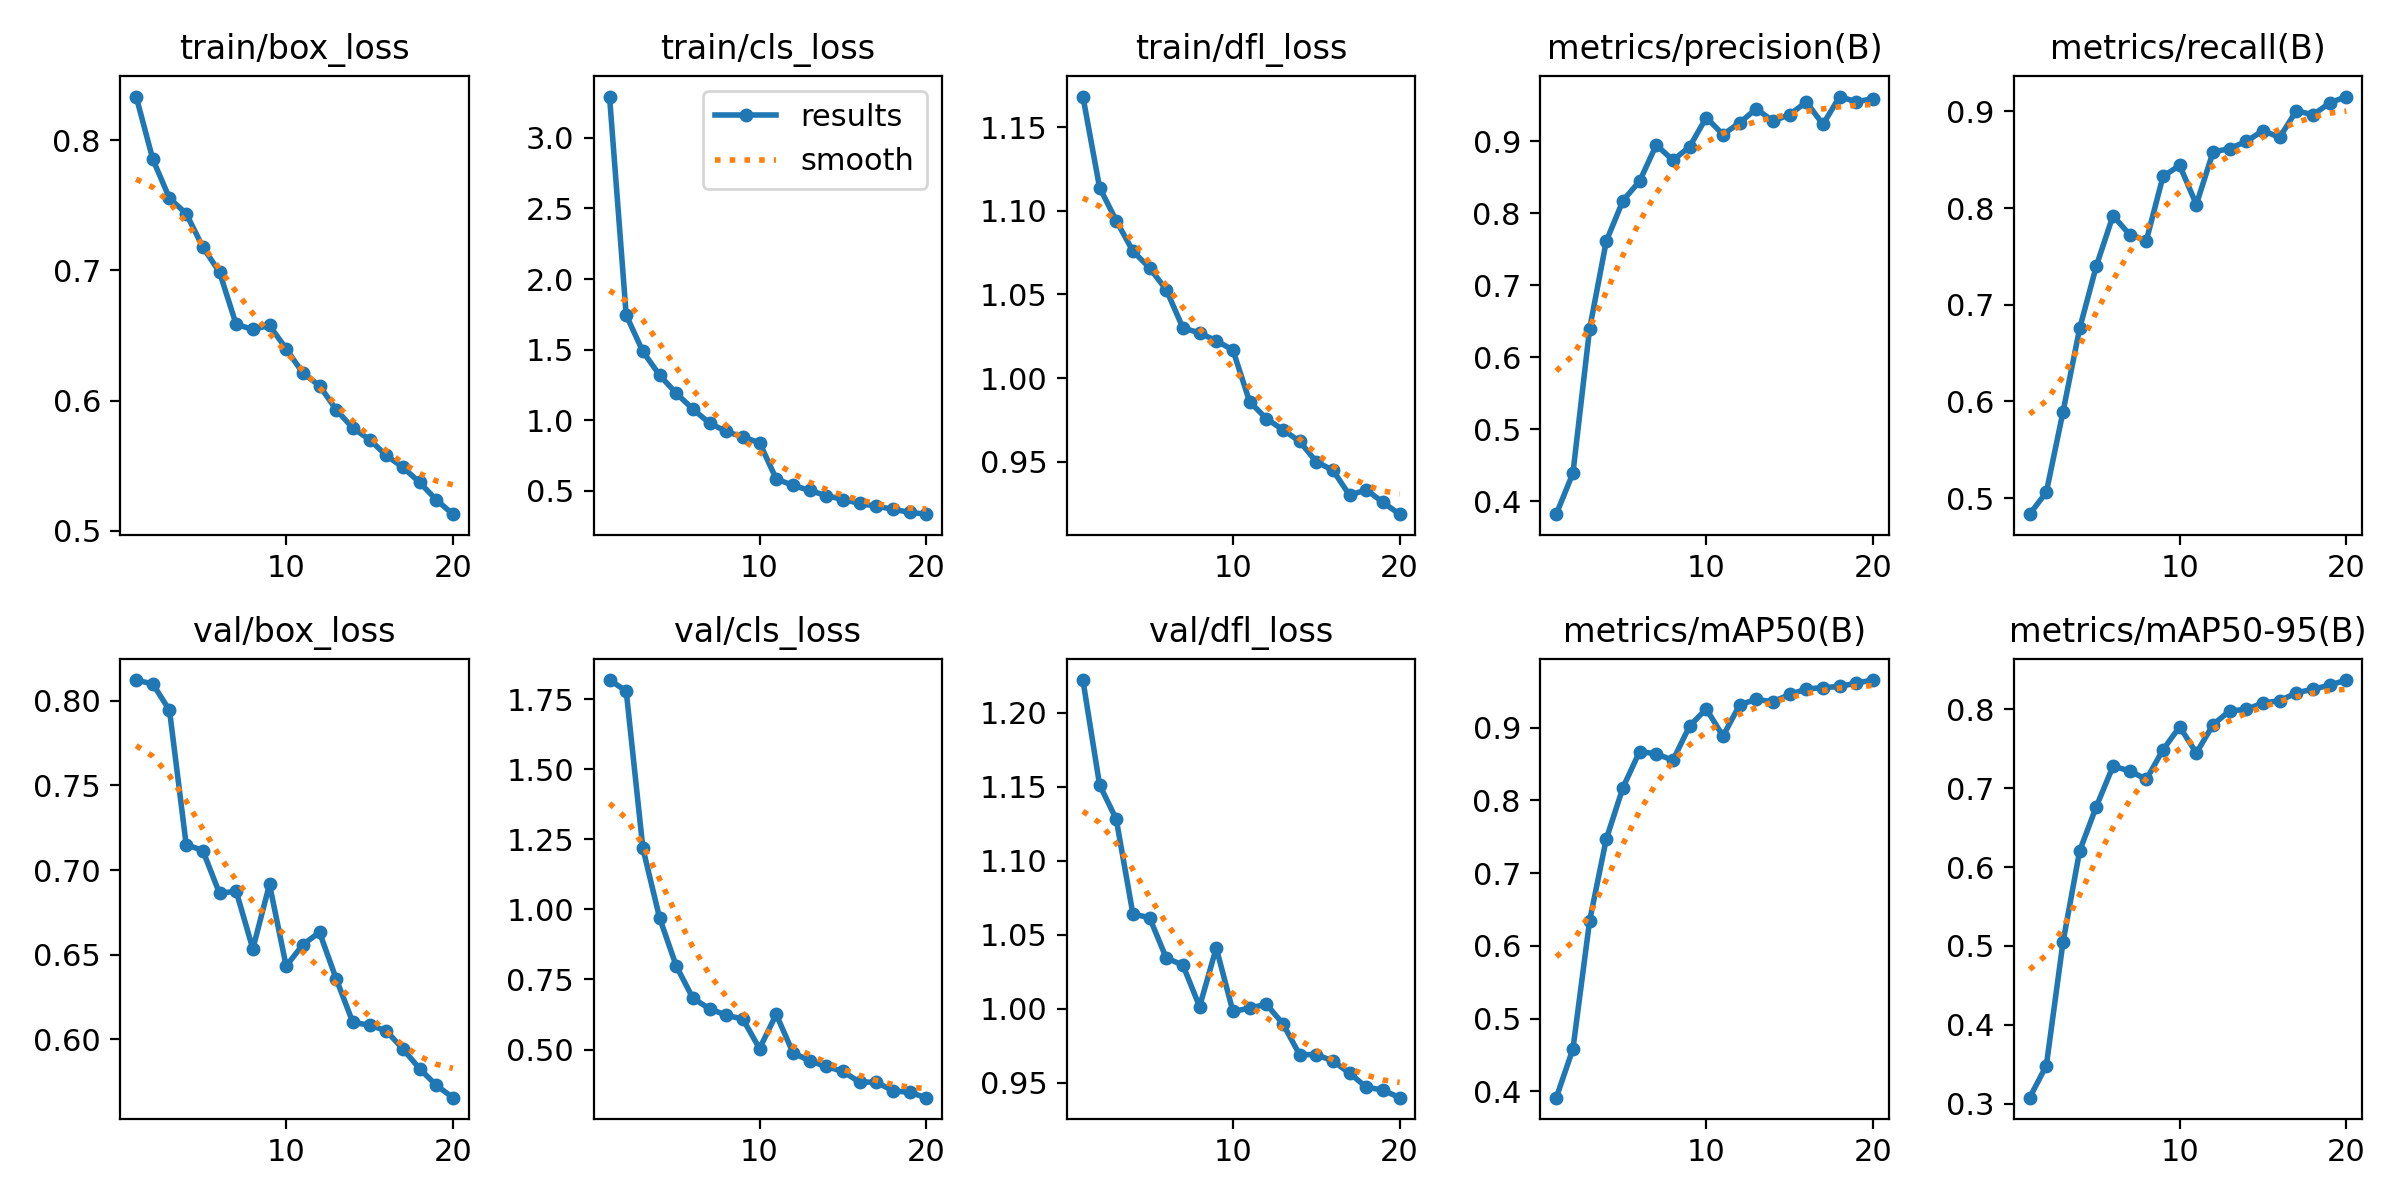

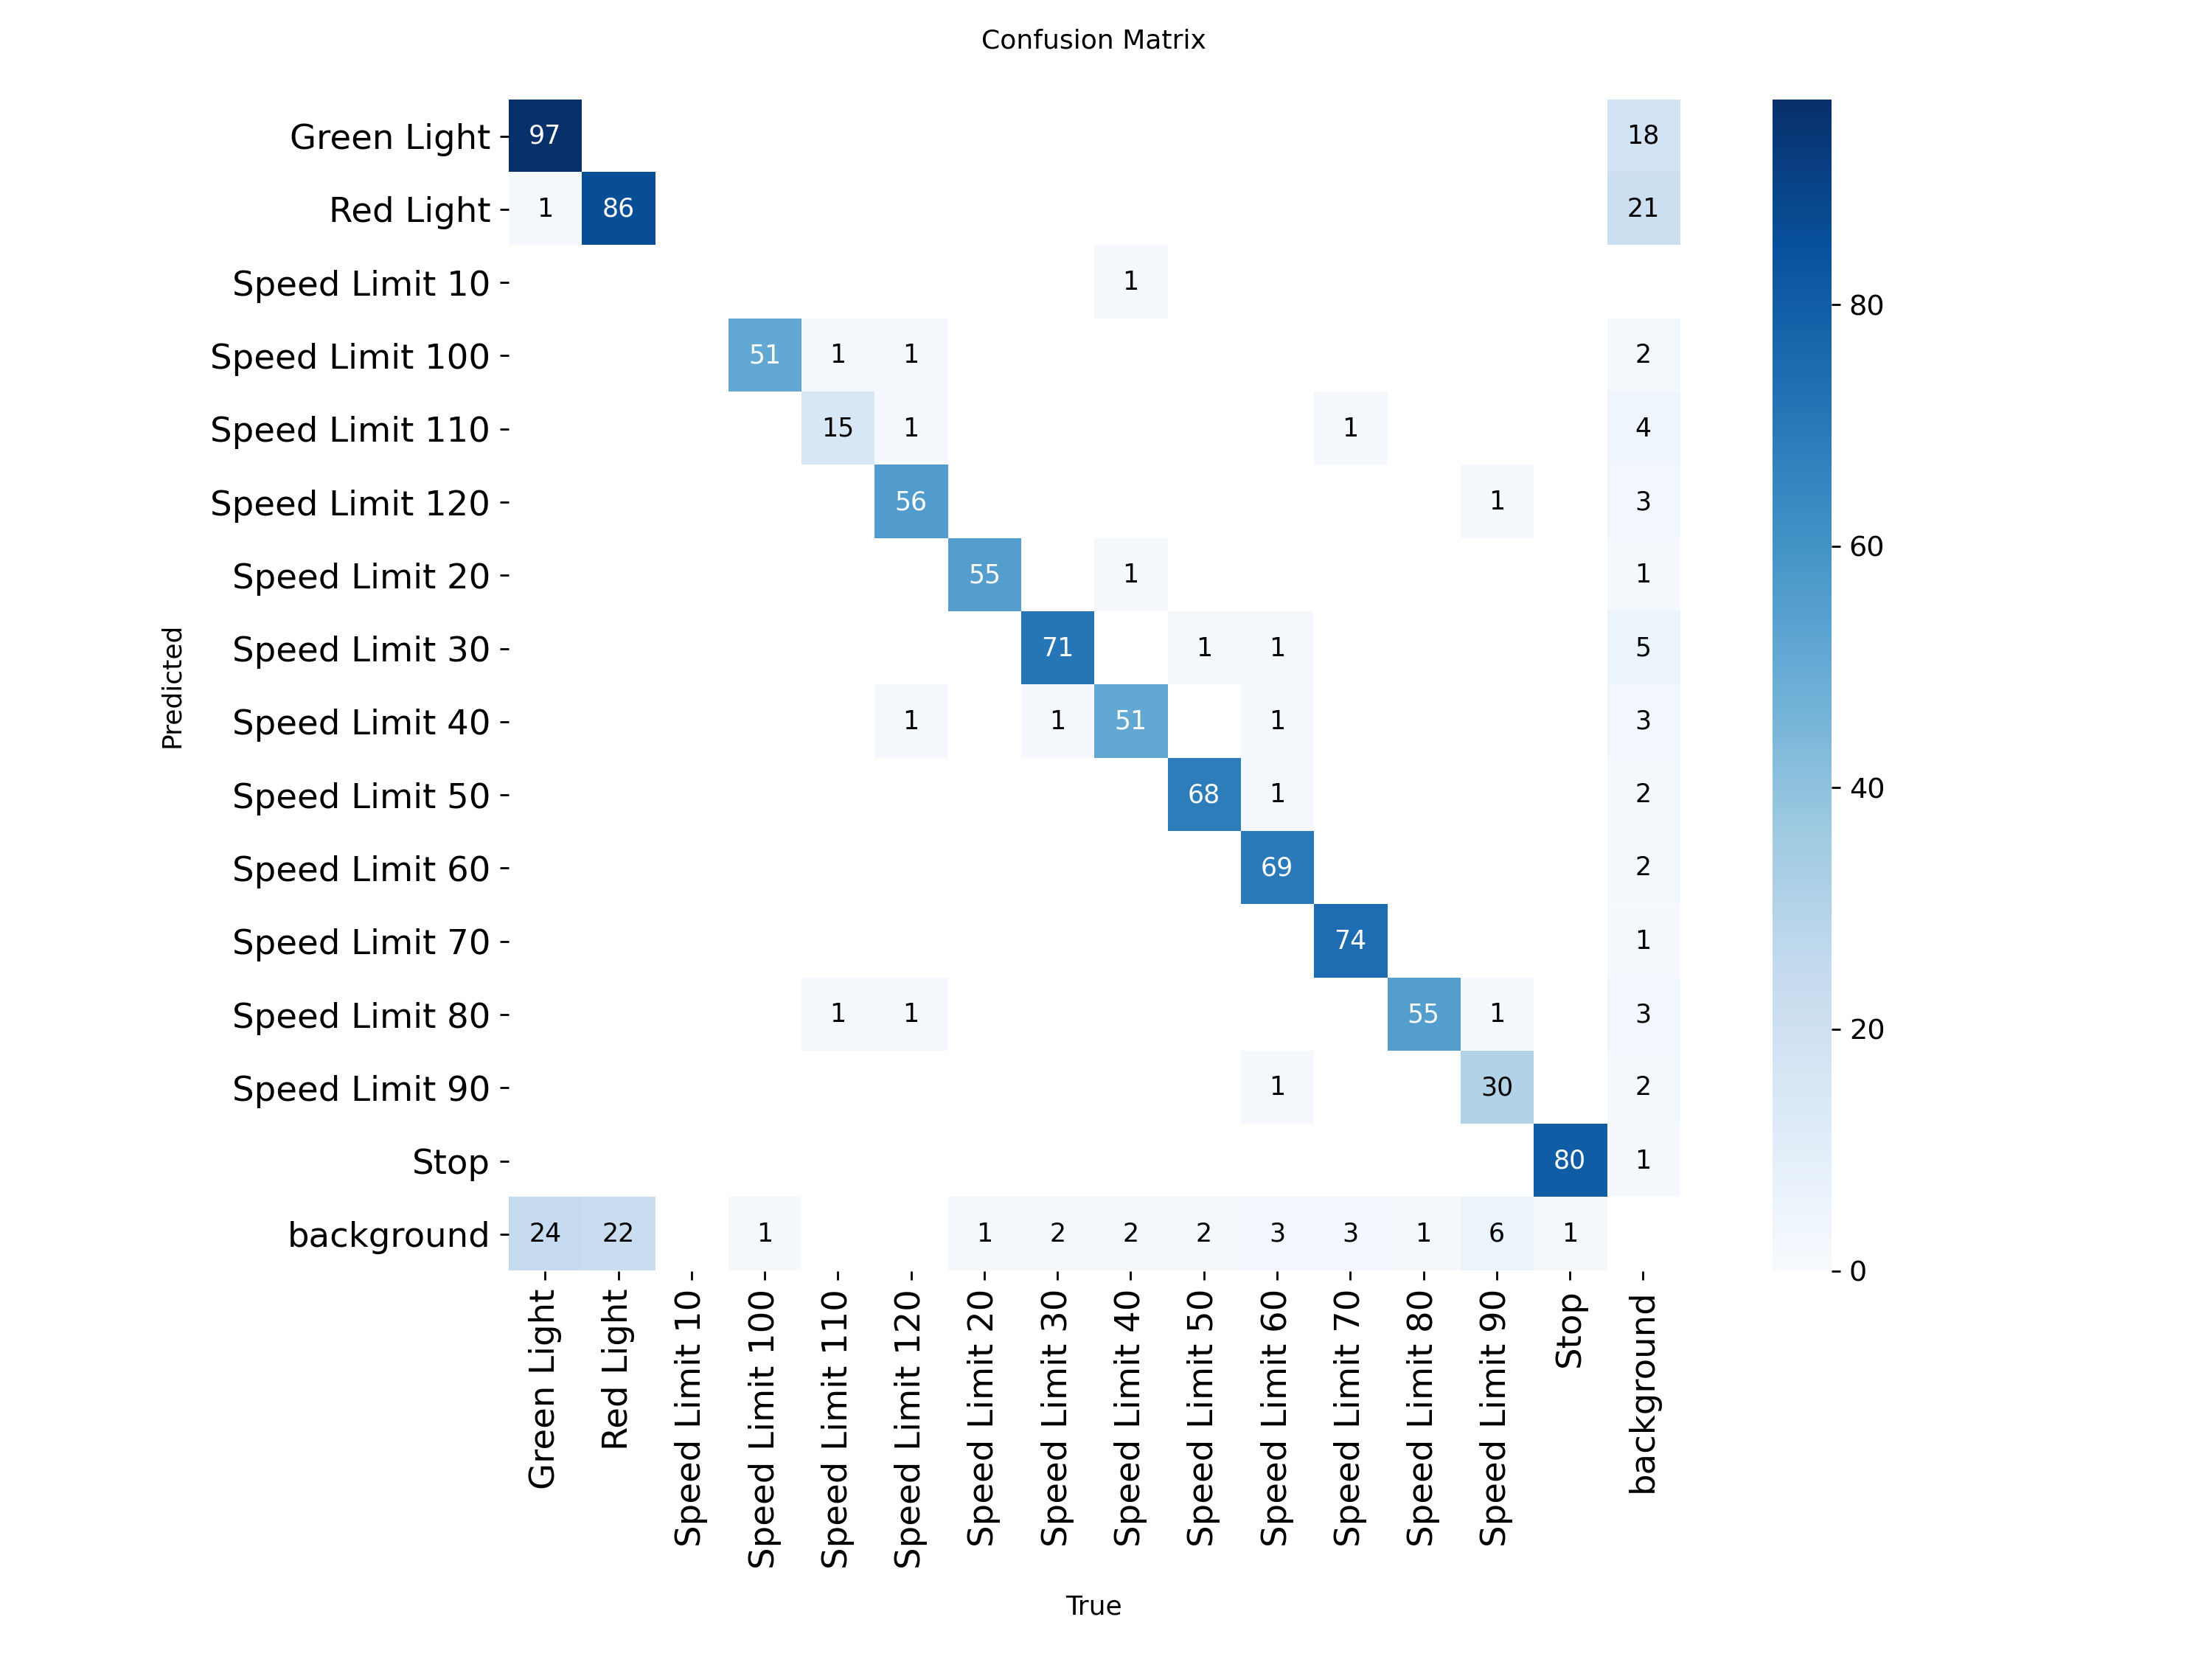

In [ ]:
# Mostrar curva de mAP y loss
from PIL import Image as PImage
display(PImage.open('runs/detect/car_yolov11s/results.png'))

# Matriz de confusión
display(PImage.open('runs/detect/car_yolov11s/confusion_matrix.png'))

**Predicción e Inferencia**

Results saved to /content/runs/detect/car_yolov11s_predict


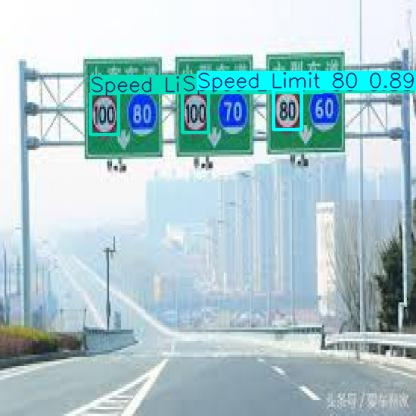

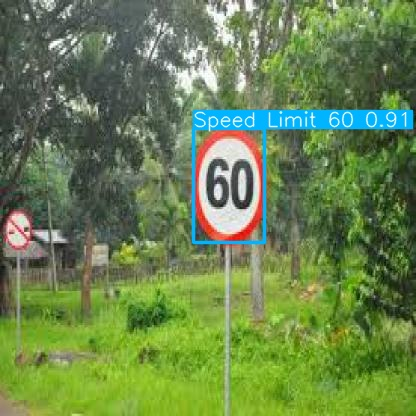

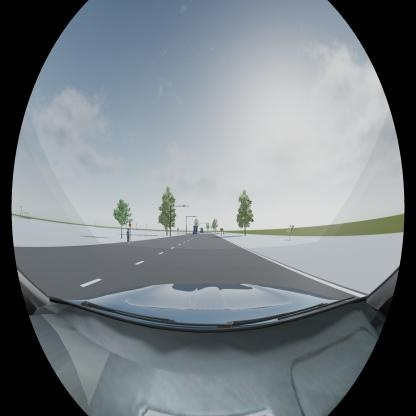

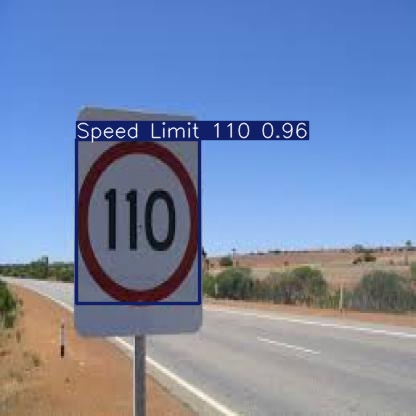

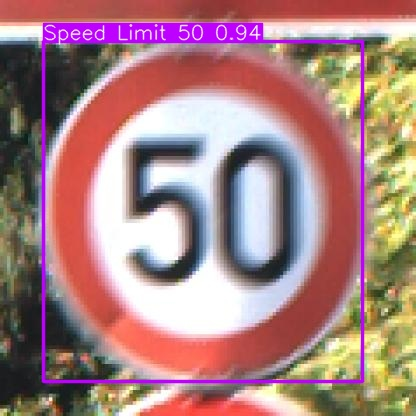

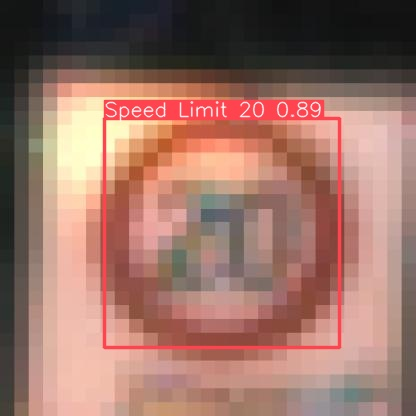

In [ ]:
# Inferencia
preds = model.predict(
    source=str(root / 'test' / 'images'),
    conf=0.25,
    save=True,
    name='car_yolov11s_predict',
    verbose=False  # Suprimir mensajes en la consola
)

# Mostrar algunas predicciones
import glob
import random
from IPython.display import display

files = glob.glob('runs/detect/car_yolov11s_predict/*.jpg')
for img in random.sample(files, 6):
    display(PImage.open(img))

### **3. Taller 2**

**Instrucciones**
1. El archivo a presentar debe ser en formato .ipynb o HTML con sus celdas ejecutadas. Celdas sin ejecutar no podrán ser evaluadas.
2. El nombre del archivo debe ser taller_2_{Apellido_Nombre}_{Apellido_Nombre} de cada integrante del equipo.
3. Las entregas solo se hacen a través de Bloque Neón.


1. **Velocidad vs. Precisión / Interpretabilidad de Resultados:**  
   - Comparar los tiempos de entrenamiento e inferencia entre las variantes `yolo11s` (small) y `yolo11n` (nano).
   - A partir de los resultados del modelo `yolo11s` y `yolo11n` qué diferencias encuentra en la evaluación de los modelos? Interprete las curvas de pérdida y los resultados del reporte de clasificación (no matriz de confusión).
   - ¿En qué escenarios es más conveniente usar cada variante (nano, small, medium, large, extra-large)? Cantidad de datos, recursos computacionales, etc.

2. **mAP50 vs. mAP50–95:**  
   - ¿Qué significa que mAP50 evalúe solo intersecciones sobre uniones (IoU) mayores o iguales a 0.5?  
   - ¿Qué información adicional proporciona evaluar el rango mAP50–95 al medir el rendimiento del modelo?

3. **Hiperparámetros críticos:**  
   - ¿Cómo afectan los valores de `batch` (tamaño de lote), `imgsz` (tamaño de imagen) y `patience` (paciencia para detener el entrenamiento) al tiempo de entrenamiento, uso de memoria y convergencia del modelo?

4. **Data Augmentation:**  
   - ¿Qué técnicas de aumento de datos podrían mejorar la capacidad del modelo para generalizar en diferentes escenarios?